In [9]:
import numpy as np
import gym
import time 
import matplotlib.pyplot as plt
import scipy
import scipy.signal
from functools import partial
from enum import Enum
import time

In [2]:
def EpsilonGreedyPolicy(Q, epsilon, state):
    # The smaller the epsilon the greedier the agent:
    if np.random.random() > epsilon: 
        return np.argmax(Q[state]) 
    else:
        #action = np.random.randint(0, env.action_space.n) 
        return  np.random.choice([0,1])

In [3]:
from gym.utils import seeding
class E_commerce_env():
    
    
    user_types = Enum('User Types', 'inexpensive_browser medium_browser luxury_browser \
    dreamers accessory_shoppers essential_shoppers impulse_buyers')              
    categories = Enum('Categories', 'inexpensive medium luxury accessory essentials')
    
    user_props = {
        user_types.inexpensive_browser: {
            'transitions': [0.7, 0.05, 0.05, 0.15, 0.05],
            'user_prob': 0.25,
            'leave_prob': 0.2,
            'buy_prob_no_prom': 0.01,
            'buy_prob_prom': 0.1
        },
        user_types.medium_browser: {
            'transitions': [0.05, 0.7, 0.05, 0.15, 0.05],
            'user_prob': 0.10,
            'leave_prob': 0.2,
            'buy_prob_no_prom': 0.01,
            'buy_prob_prom': 0.1
        },
        user_types.luxury_browser: {
            'transitions': [0.0, 0.05, 0.8, 0.0, 0.15],
            'user_prob': 0.01,
            'leave_prob': 0.3,
            'buy_prob_no_prom': 0.05,
            'buy_prob_prom': 0.5
        },
        user_types.dreamers: {
            'transitions': [0.25, 0.25, 0.25, 0.10, 0.15],
            'user_prob': 0.20,
            'leave_prob': 0.1,
            'buy_prob_no_prom': 0.0,
            'buy_prob_prom': 0.01
        },
        user_types.accessory_shoppers: {
            'transitions': [0.0, 0.0, 0.0, 0.80, 0.2],
            'user_prob': 0.25,
            'leave_prob': 0.5,
            'buy_prob_no_prom': 0.25,
            'buy_prob_prom': 0.5
        },
        user_types.essential_shoppers: {
            'transitions': [0.0, 0.0, 0.0, 0.80, 0.2],
            'user_prob': 0.10,
            'leave_prob': 0.5,
            'buy_prob_no_prom': 0.25,
            'buy_prob_prom': 0.5
        },
        user_types.impulse_buyers: {
            'transitions': [0.25, 0.25, 0.0, 0.25, 0.25],
            'user_prob': 0.09,
            'leave_prob': 0.3,
            'buy_prob_no_prom': 0.05,
            'buy_prob_prom': 1.0
        }
    }
    
    category_props = {
        categories.inexpensive: {
            'sale_price': 300,
            'cost': 50
        },
        categories.medium: {
            'sale_price': 1000,
            'cost': 300
        },
        categories.luxury: {
            'sale_price': 5000,
            'cost': 4500
        },
        categories.accessory: {
            'sale_price': 50,
            'cost': 25
        },
        categories.essentials: {
            'sale_price': 100,
            'cost': 10
        }
    }
    
    def __init__(self):
        
        self.initial_state = [0]*5
        
        self.seed()

    def seed(self, seed=None):
        self.state = seeding.np_random(seed)
        return [seed]
        
    def reset(self):
        self.u=[]
        self.p=[]
        self.profit=0

        for user_type in self.user_types:
            self.u.append(user_type)
            self.p.append(self.user_props[user_type]['user_prob'])    
        self.user_type = np.random.choice(self.u, p=self.p)
        
        self.first_page = np.random.choice(self.categories, p=self.user_props[user_type]['transitions'])
        
        self.initial_state[1:] = self.initial_state[0:4]
        self.initial_state[0] = self.first_page.value
        
        stat=[[self.user_type],self.initial_state]
        self.state=[item for sublist in stat for item in sublist]
        
        return self.state
    
        
    def step(self, action):

        user_type= self.state[0]
        history=self.state[1:]

        while True:

            if action == 0:
                buy_prob = self.user_props[user_type]['buy_prob_no_prom']
            else:
                buy_prob = self.user_props[user_type]['buy_prob_prom']

            buy = np.random.choice([True, False], p=[buy_prob, 1-buy_prob]) 


            if buy:
                reward=1.0
                history=[6]+history[0:4]

                sale = self.category_props[self.first_page]['sale_price']
                self.profit += 0.8*sale if action else sale
                self.profit -= self.category_props[self.first_page]['cost']
                break
            else:
                reward=0.0

                leave_prob = self.user_props[user_type]['leave_prob']
                leave = np.random.choice([True, False], p=[leave_prob, 1-leave_prob])

                if leave:
                    reward=0.0
                    history=[7]+history[0:4]
                    break

            next_page = np.random.choice(self.categories, p=self.user_props[user_type]['transitions'])
            history[1:] = history[0:4]
            history[0] = next_page.value

        return [user_type.value]+history, reward 
       

In [4]:
# monte carlo 
class MC(object):
    def __init__(self, env, num_states, num_actions, gamma=1, eps=0.1, eps_decay=0.9999, first_visit=True,
                  render=True, max_iter=10000):
        self.env=env
        self.num_states = num_states
        self.num_actions = num_actions
        self.first_visit = first_visit

        self.gamma = gamma
        self.eps = eps
        self.eps_decay = eps_decay
        self.max_iter=max_iter
        self.render=render

        self.Q = np.random.uniform(low = -1, high = 1, 
                          size =(self.num_states, self.num_actions))
        self.Q_num = np.zeros((self.num_states, self.num_actions))
        self.visited_num = np.zeros((self.num_states, self.num_actions))

    def update_Q(self):
        
        obs = self.env.reset()    
        policy = partial(EpsilonGreedyPolicy, self.Q, self.eps)

        rewards = []
        actions = []
        states = []
    
        for _ in range(self.max_iter):
            state_idx = []
            flatten_index=0
        
            action = policy(flatten_index)
            
            # save state and action taken in this step
            actions.append(action)
            states.append(flatten_index)

            # take an action    
            [obs, rew ] = env.step(action)
            # Save the reward after the action has been taken
            rewards.append(rew)


        updated_states = set()
        discounted_rewards=scipy.signal.lfilter([1],[1,-self.gamma], np.array(rewards)[::-1], axis=0)[::-1]
        
        for state, action, disc_rew in zip(states, actions, discounted_rewards):

            if self.first_visit:
                if state in updated_states:
                    continue

                updated_states.add(state)

            # incremental averaging
            
            # count the number of state-=action pairs visited in this episode
            self.Q_num[state, action] += 1
            
            # compute the average aproximation for the Q-tensor from this episode
            self.Q[state, action] += (disc_rew - self.Q[state, action]) / self.Q_num[state, action]
            self.visited_num[state, action] += 1
            rewards_in_episode= np.sum(np.array(rewards))

        self.eps *= self.eps_decay

        return rewards_in_episode, self.Q


In [5]:
if __name__ == '__main__':
    class Average(object):
        def __init__(self, N):
            self.N = N
            self.vals = []
            self.num_filled = 0

        def pop(self, val):
            if self.num_filled == self.N:
                self.vals.pop(0)
                self.vals.append(val)
            else:
                self.vals.append(val)
                self.num_filled += 1
                return self.vals, self.num_filled, self.N

        def get_avg(self):
            return float(sum(self.vals)) / self.num_filled

Iteration 0 reward: 1897.0
Iteration 10 reward: 610.0
Iteration 20 reward: 41.0
Iteration 30 reward: 3443.0
Iteration 40 reward: 6623.0
Iteration 50 reward: 9593.0
Iteration 60 reward: 6523.0
Iteration 70 reward: 3449.0
Iteration 80 reward: 6570.0
Iteration 90 reward: 3372.0
Iteration 100 reward: 3474.0
Iteration 110 reward: 6485.0
Iteration 120 reward: 3408.0
Iteration 130 reward: 6524.0
Iteration 140 reward: 3387.0
Iteration 150 reward: 3414.0
Iteration 160 reward: 9550.0
Iteration 170 reward: 904.0
Iteration 180 reward: 3461.0
Iteration 190 reward: 3393.0


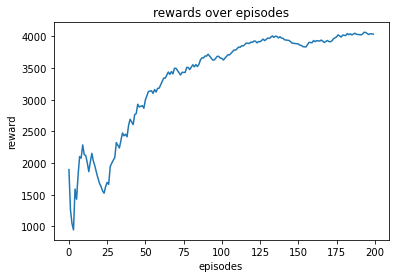

In [6]:
#load the enviroment
env = E_commerce_env()

num_actions = 2  # number of actions of the enviroment: show_prom=0, not_show_prom=1
num_states = [7,8,8,8,8,8]  # number of states: [user_type, history_1,history_5] 

state_space_dim = np.prod(np.array(num_states)) # dimension of the state space

#  MC(env, num_states, num_actions, gamma=1, eps=0.1, eps_decay=0.9999, first_visit=True,
#                  render=True, max_iter=100000):
mc = MC(env,state_space_dim , num_actions,eps=0.1, first_visit=True)

num_episodes = 200

rewards = np.zeros(num_episodes)
avg_calc = Average(200)
for i in range(num_episodes):
    total_reward, Q = mc.update_Q()
    avg_calc.pop(total_reward)
    rewards[i] = avg_calc.get_avg()
    if i%10==0:
        print("Iteration " + str(i) + " reward: " + str(total_reward))

plt.plot(rewards)
plt.title('rewards over episodes')
plt.xlabel('episodes')
plt.ylabel('reward')
plt.show()
